In [1]:
import os
import torch
import numpy as np
import open3d as o3d
import yaml
from pathlib import Path
import plotly.graph_objects as go

try:
    import open3d.ml.torch as ml3d
    import open3d.ml as o3dml
    print("Open3D-ML successfully imported")
except ImportError as e:
    print("Error importing Open3D-ML")
    print(e)

print(f"Torch version: {torch.__version__}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

Open3D-ML successfully imported
Torch version: 1.13.1
Device: CPU


In [2]:
!python generate_dataset.py \
    --output_dir data/scannet_primitives \
    --num_train 100 \
    --num_val 20 \
    --num_test 20 \
    --points_per_object 1024

Generating train scene scene0000_00...
Generating train scene scene0001_00...
Generating train scene scene0002_00...
Generating train scene scene0003_00...
Generating train scene scene0004_00...
Generating train scene scene0005_00...
Generating train scene scene0006_00...
Generating train scene scene0007_00...
Generating train scene scene0008_00...
Generating train scene scene0009_00...
Generating train scene scene0010_00...
Generating train scene scene0011_00...
Generating train scene scene0012_00...
Generating train scene scene0013_00...
Generating train scene scene0014_00...
Generating train scene scene0015_00...
Generating train scene scene0016_00...
Generating train scene scene0017_00...
Generating train scene scene0018_00...
Generating train scene scene0019_00...
Generating train scene scene0020_00...
Generating train scene scene0021_00...
Generating train scene scene0022_00...
Generating train scene scene0023_00...
Generating train scene scene0024_00...
Generating train scene sc

In [2]:
from pathlib import Path
import numpy as np
import yaml
import open3d.ml as o3dml

class BoundingBox3D:
    def __init__(self, center, size, label_class, name):
        self.center = np.array(center, dtype=np.float32)
        self.size = np.array(size, dtype=np.float32)
        self.label_class = label_class
        self.name = name
        self.rotation = np.eye(3, dtype=np.float32)
        self.confidence = 1.0 
        
    def to_numpy(self):
        return np.concatenate([self.center, self.size, [0.0]]) # 0.0 - angle

class ScannetPrimitivesDet(o3dml.datasets.Scannet):
    def __init__(self, dataset_path, scannet_yaml_path, name="ScannetPrimitivesDet", **kwargs):
        super().__init__(dataset_path=dataset_path, name=name, **kwargs)
        
        self._scannet_yaml_path = scannet_yaml_path
        with open(scannet_yaml_path, "r") as f:
            cfg = yaml.safe_load(f)
            
        self.classes = cfg["classes"]
        self.cat2label = {cat: i for i, cat in enumerate(self.classes)}
        self.label2cat = {i: cat for i, cat in enumerate(self.classes)}
        self.cat_ids2class = {i: i for i in range(len(self.classes))}

    def read_label(self, scene_name):
        scene_path = Path(scene_name)
    
        if scene_path.is_absolute() or str(self.dataset_path) in str(scene_path):
             base_dir = scene_path.parent
             name_only = scene_path.name
        else:
             base_dir = Path(self.dataset_path)
             name_only = scene_name

        bbox_path = base_dir / f"{name_only}_bbox.npy"
        sem_path = base_dir / f"{name_only}_sem_label.npy"
        ins_path = base_dir / f"{name_only}_ins_label.npy"
    
        if str(name_only).endswith('.npy'):
             stem = Path(name_only).stem.replace('_bbox', '').replace('_sem_label', '').replace('_ins_label', '')
             bbox_path = base_dir / f"{stem}_bbox.npy"
             sem_path = base_dir / f"{stem}_sem_label.npy"
             ins_path = base_dir / f"{stem}_ins_label.npy"

        if not bbox_path.exists():
            bbox_path = Path(self.dataset_path) / f"{Path(name_only).name}_bbox.npy"
            sem_path = Path(self.dataset_path) / f"{Path(name_only).name}_sem_label.npy"
            ins_path = Path(self.dataset_path) / f"{Path(name_only).name}_ins_label.npy"
        
            if not bbox_path.exists():
                 raise FileNotFoundError(f"Label file not found: {bbox_path}")

        bboxes = np.load(bbox_path)
        semantic_mask = np.load(sem_path)
        instance_mask = np.load(ins_path)
    
        objects = []
        for box in bboxes:
            # box: [cx, cy, cz, dx, dy, dz, label_id]
            label_id = int(box[6])
            
            if label_id in self.label2cat:
                name = self.label2cat[label_id]
            else:
                name = "unknown"
            
            center = box[:3]
            size = box[3:6]
        
            objects.append(BoundingBox3D(center, size, label_id, name))
        
        return objects, semantic_mask, instance_mask

# Инициализация
dataset = ScannetPrimitivesDet(
    dataset_path="data/scannet_primitives",
    scannet_yaml_path="configs/scannet_primitives.yaml"
)

# Проверка
split = dataset.get_split("train")
sample = split.get_data(0)
print(f"Sample points: {sample['point'].shape}")
print(f"Sample boxes: {len(sample['bounding_boxes'])}")
if len(sample['bounding_boxes']) > 0:
    print(f"First box label: {sample['bounding_boxes'][0].label_class} ({sample['bounding_boxes'][0].name})")

Sample points: (10240, 3)
Sample boxes: 5
First box label: 2 (sphere)


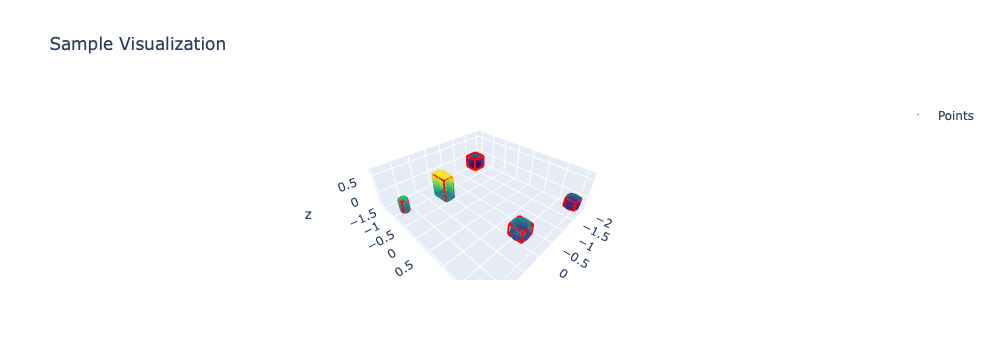

In [3]:
def visualize_sample_plotly(points, bboxes, title="Sample Visualization"):
    fig = go.Figure()
    
    # Облако точек
    fig.add_trace(go.Scatter3d(
        x=points[:,0], y=points[:,1], z=points[:,2],
        mode='markers',
        marker=dict(size=2, color=points[:,2], colorscale='Viridis', opacity=0.5),
        name='Points'
    ))
    
    # Боксы
    for box in bboxes:
        # box: center(3), size(3), label(1), [yaw/rot]
        # BoundingBox3D
        center = box.center
        size = box.size
        
        dx, dy, dz = size / 2
        corners = np.array([
            [-dx, -dy, -dz], [dx, -dy, -dz], [dx, dy, -dz], [-dx, dy, -dz],
            [-dx, -dy, dz], [dx, -dy, dz], [dx, dy, dz], [-dx, dy, dz]
        ])
        # Вращаем
        corners = corners @ box.rotation.T + center
        
        # Линии
        lines = [[0,1],[1,2],[2,3],[3,0], [4,5],[5,6],[6,7],[7,4], [0,4],[1,5],[2,6],[3,7]]
        for start, end in lines:
            fig.add_trace(go.Scatter3d(
                x=[corners[start,0], corners[end,0]],
                y=[corners[start,1], corners[end,1]],
                z=[corners[start,2], corners[end,2]],
                mode='lines', line=dict(color='red', width=4), showlegend=False
            ))

    fig.update_layout(title=title, scene=dict(aspectmode='data'))
    fig.show()

# Тест визуализации
visualize_sample_plotly(sample['point'], sample['bounding_boxes'])

Loading train dataset...
Loading val dataset...
Starting Training...
Epoch 1/25 | mAP@0.6: 0.0000
Epoch 2/25 | mAP@0.6: 0.0000
Epoch 3/25 | mAP@0.6: 0.0000
Epoch 4/25 | mAP@0.6: 0.0000
Epoch 5/25 | mAP@0.6: 0.2683
Epoch 6/25 | mAP@0.6: 0.1789
Epoch 7/25 | mAP@0.6: 0.2439
Epoch 8/25 | mAP@0.6: 0.3252
Epoch 9/25 | mAP@0.6: 0.0894
Epoch 10/25 | mAP@0.6: 0.5285
Epoch 11/25 | mAP@0.6: 0.7480
Epoch 12/25 | mAP@0.6: 0.3984
Epoch 13/25 | mAP@0.6: 0.4553
Epoch 14/25 | mAP@0.6: 0.3252
Epoch 15/25 | mAP@0.6: 0.6585
Epoch 16/25 | mAP@0.6: 0.4959
Epoch 17/25 | mAP@0.6: 0.0081
Epoch 18/25 | mAP@0.6: 0.7642
Epoch 19/25 | mAP@0.6: 0.6585
Epoch 20/25 | mAP@0.6: 0.7154
Epoch 21/25 | mAP@0.6: 0.3252
Epoch 22/25 | mAP@0.6: 0.7967
Epoch 23/25 | mAP@0.6: 0.7642
Epoch 24/25 | mAP@0.6: 0.7642
Epoch 25/25 | mAP@0.6: 0.7236


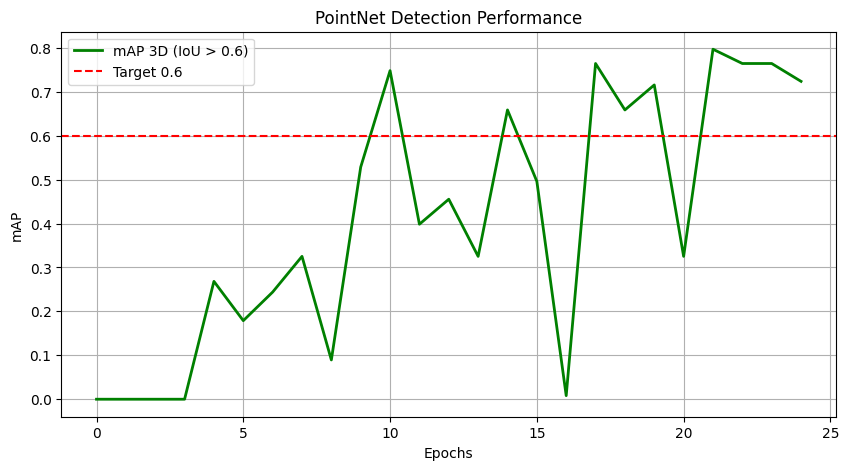

Loading val dataset...


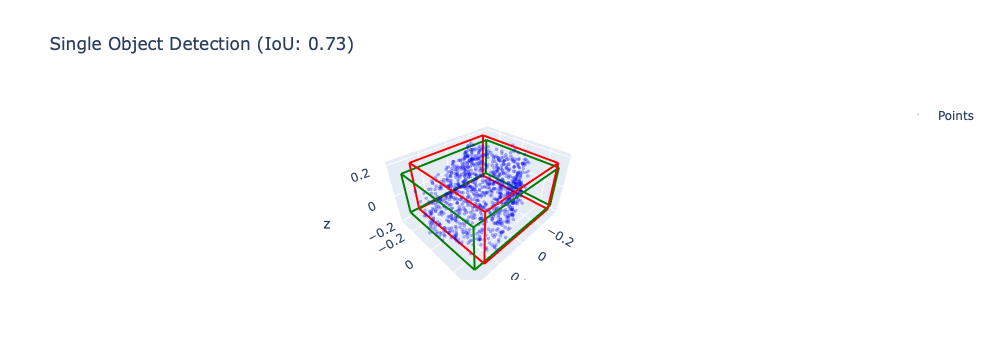

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from pathlib import Path
import glob

# Утилиты 
def box3d_iou(pred_box, gt_box):
    p_c, p_s = pred_box[:3], pred_box[3:]
    g_c, g_s = gt_box[:3], gt_box[3:]
    p_min = p_c - p_s / 2
    p_max = p_c + p_s / 2
    g_min = g_c - g_s / 2
    g_max = g_c + g_s / 2
    inter_min = np.maximum(p_min, g_min)
    inter_max = np.minimum(p_max, g_max)
    inter_dims = np.maximum(inter_max - inter_min, 0)
    inter_vol = np.prod(inter_dims)
    p_vol = np.prod(p_s)
    g_vol = np.prod(g_s)
    union_vol = p_vol + g_vol - inter_vol
    return inter_vol / (union_vol + 1e-6)

# Датасет 
class PrimitivesObjectDataset(Dataset):
    def __init__(self, data_dir, split='train', n_points=1024):
        self.files = glob.glob(f"{data_dir}/scene*_bbox.npy")
        self.n_points = n_points
        self.items = []
        split_idx = int(len(self.files) * 0.8)
        if split == 'train': self.files = self.files[:split_idx]
        else: self.files = self.files[split_idx:]
        print(f"Loading {split} dataset...")
        
        for bbox_file in self.files:
            scene_id = bbox_file.split('_bbox.npy')[0]
            try:
                verts = np.load(f"{scene_id}_vert.npy")[:, :3]
                instances = np.load(f"{scene_id}_ins_label.npy")
                bboxes = np.load(bbox_file)
                for inst_id in np.unique(instances):
                    mask = instances == inst_id
                    obj_points = verts[mask]
                    if len(obj_points) < 50: continue
                    if inst_id < len(bboxes):
                        self.items.append({'points': obj_points, 'box': bboxes[inst_id][:6]})
            except: continue
                
    def __len__(self): return len(self.items)
    def __getitem__(self, idx):
        item = self.items[idx]
        pts = item['points']
        box = item['box']
        if len(pts) > 0:
            choice = np.random.choice(len(pts), self.n_points, replace=True)
            pts = pts[choice]
        else: pts = np.zeros((self.n_points, 3))
        
        noise = np.random.normal(0, 0.02, pts.shape) 
        pts = pts + noise
        shift = np.random.uniform(-0.2, 0.2, 3)
        pts = pts + shift
        box_final = box.copy()
        box_final[:3] += shift
        centroid = np.mean(pts, axis=0)
        pts = pts - centroid
        box_final[:3] -= centroid
        return {'points': torch.from_numpy(pts.astype(np.float32)), 'target': torch.from_numpy(box_final.astype(np.float32))}

# Модель 
class PointNetDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 6)
        self.drop = nn.Dropout(0.3) 

    def forward(self, x):
        x = x.transpose(2, 1)
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        x = torch.relu(self.fc1(x))
        x = self.drop(torch.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# Обучение 
def train_task20_hard():
    train_ds = PrimitivesObjectDataset("data/scannet_primitives", split='train')
    val_ds = PrimitivesObjectDataset("data/scannet_primitives", split='val')
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
    
    model = PointNetDetector()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    history = {'map': []}
    epochs = 25 
    print("Starting Training...")
    
    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            pts, target = batch['points'], batch['target']
            optimizer.zero_grad()
            preds = model(pts)
            loss = criterion(preds, target)
            loss.backward()
            optimizer.step()
            
        model.eval()
        correct = 0; total = 0
        with torch.no_grad():
            for batch in val_loader:
                pts, target = batch['points'], batch['target']
                preds = model(pts)
                p_np, t_np = preds.numpy(), target.numpy()
                for i in range(len(p_np)):
                    if box3d_iou(p_np[i], t_np[i]) > 0.6: correct += 1
                    total += 1
        
        map_3d = correct / total if total > 0 else 0
        history['map'].append(map_3d)
        print(f"Epoch {epoch+1}/{epochs} | mAP@0.6: {map_3d:.4f}")

    plt.figure(figsize=(10, 5))
    plt.plot(history['map'], label='mAP 3D (IoU > 0.6)', linewidth=2, color='green')
    plt.axhline(y=0.6, color='r', linestyle='--', label='Target 0.6')
    plt.title('PointNet Detection Performance')
    plt.xlabel('Epochs'); plt.ylabel('mAP'); plt.legend(); plt.grid(True)
    plt.show()
    
    return model 

# Визуализация 
def visualize_single_object(model):
    val_ds = PrimitivesObjectDataset("data/scannet_primitives", split='val')
    idx = np.random.randint(0, len(val_ds))
    sample = val_ds[idx]
    pts = sample['points'] # [1024, 3]
    gt_box = sample['target'].numpy()
    
    # Инференс
    model.eval()
    with torch.no_grad():
        # [1, 1024, 3]
        pred_box = model(pts.unsqueeze(0)).numpy()[0]
        
    fig = go.Figure()
    
    # Точки
    fig.add_trace(go.Scatter3d(
        x=pts[:,0], y=pts[:,1], z=pts[:,2],
        mode='markers', marker=dict(size=2, color='blue', opacity=0.3),
        name='Points'
    ))
    
    # Функция для бокса
    def draw_wireframe(box, color, name):
        cx, cy, cz, dx, dy, dz = box
        # Углы
        dx, dy, dz = abs(dx)/2, abs(dy)/2, abs(dz)/2
        corners = np.array([
            [-dx, -dy, -dz], [dx, -dy, -dz], [dx, dy, -dz], [-dx, dy, -dz],
            [-dx, -dy, dz], [dx, -dy, dz], [dx, dy, dz], [-dx, dy, dz]
        ])
        corners += [cx, cy, cz]
        lines = [[0,1],[1,2],[2,3],[3,0], [4,5],[5,6],[6,7],[7,4], [0,4],[1,5],[2,6],[3,7]]
        
        for start, end in lines:
            fig.add_trace(go.Scatter3d(
                x=[corners[start,0], corners[end,0]],
                y=[corners[start,1], corners[end,1]],
                z=[corners[start,2], corners[end,2]],
                mode='lines', line=dict(color=color, width=4), showlegend=False,
                name=name
            ))
            
    draw_wireframe(gt_box, 'green', 'Ground Truth')
    draw_wireframe(pred_box, 'red', 'Prediction')
    
    fig.update_layout(title=f"Single Object Detection (IoU: {box3d_iou(pred_box, gt_box):.2f})", scene=dict(aspectmode='data'))
    fig.show()

# Запуск
if __name__ == "__main__":
    trained_model = train_task20_hard()
    visualize_single_object(trained_model)